## Carga modulo comun

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../common'))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from purrfect.dataset import EPKADataset, load_partition,save_partition, create_train_valid_loaders
from torch.utils.data import DataLoader

from purrfect.training import train_model,train_validate
import torch.optim as optim

from purrfect.metrics import MetricAccumulator
from purrfect.active_learning import create_new_partition,create_next_partitions, test_model

from sklearn.model_selection import train_test_split
from purrfect.submission import create_submission, create_submission_v2

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_AUTOCAST =  False

## Definición modelo

In [4]:
# Define the double convolution block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class ChannelAdder(nn.Module):
    def __init__(self):
        super(ChannelAdder, self).__init__()
        # Define Sobel and Laplacian kernels as tensors
        self.sobel_x = torch.tensor([[-1., 0., 1.],
                                     [-2., 0., 2.],
                                     [-1., 0., 1.]], dtype=torch.float32,device=DEVICE).unsqueeze(0).unsqueeze(0)
        
        self.sobel_y = torch.tensor([[-1., -2., -1.],
                                     [ 0.,  0.,  0.],
                                     [ 1.,  2.,  1.]], dtype=torch.float32,device=DEVICE).unsqueeze(0).unsqueeze(0)
        
        self.laplacian_kernel = torch.tensor([[0.,  1., 0.],
                                              [1., -4., 1.],
                                              [0.,  1., 0.]], dtype=torch.float32,device=DEVICE).unsqueeze(0).unsqueeze(0)

    def forward(self, x):
        epsilon = 1e-8

        # Extract the first, second, and third channels
        first_channel = x[:, 0, :, :].unsqueeze(1)  # e1 (first channel)
        second_channel = x[:, 1, :, :].unsqueeze(1)  # e2 (second channel)
        third_channel = x[:, 2, :, :].unsqueeze(1)  # error (third channel)

        # 1. Compute the first new channel: sqrt(first_channel^2 + second_channel^2)
        new_channel1 = torch.sqrt(first_channel**2 + second_channel**2)

        # 2. Compute the second new channel: 1/2 * arctan(channel2 / channel1)
        new_channel2 = 0.5 * torch.atan(second_channel / (first_channel + epsilon))

        # 3. Compute Sobel gradients and Laplacians for e1 (first_channel)
        grad_e1_x = F.conv2d(first_channel, self.sobel_x, padding=1)
        grad_e1_y = F.conv2d(first_channel, self.sobel_y, padding=1)
        grad_e1_magnitude = torch.sqrt(grad_e1_x**2 + grad_e1_y**2)
        #laplacian_e1 = F.conv2d(first_channel, self.laplacian_kernel, padding=1)

        # 4. Compute Sobel gradients and Laplacians for e2 (second_channel)
        grad_e2_x = F.conv2d(second_channel, self.sobel_x, padding=1)
        grad_e2_y = F.conv2d(second_channel, self.sobel_y, padding=1)
        grad_e2_magnitude = torch.sqrt(grad_e2_x**2 + grad_e2_y**2)
        #laplacian_e2 = F.conv2d(second_channel, self.laplacian_kernel, padding=1)

        # 5. Compute weighted ellipticity channels (e1_weighted, e2_weighted)
        e1_weighted = first_channel / (third_channel + epsilon)
        e2_weighted = second_channel / (third_channel + epsilon)

        # Concatenate all the channels (original and new) into the output tensor
        output = torch.cat([
            x,                 # Original 3 channels
            new_channel1,      # sqrt(channel1^2 + channel2^2)
            new_channel2,      # 1/2 * arctan(channel2 / channel1)
            #grad_e1_x,         # Gradient X of channel1
            #grad_e1_y,         # Gradient Y of channel1
            #grad_e2_x,         # Gradient X of channel2
            #grad_e2_y,         # Gradient Y of channel2
            grad_e1_magnitude, # Gradient magnitude of channel1
            grad_e2_magnitude, # Gradient magnitude of channel2
            #laplacian_e1,      # Laplacian of channel1
            #laplacian_e2,      # Laplacian of channel2
            e1_weighted,       # e1_weighted
            e2_weighted        # e2_weighted
        ], dim=1)

        return output

# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Channel Adder
        self.channel_adder = ChannelAdder()
        # Encoder
        self.encoder1 = DoubleConv(in_channels+6, 64)
        self.encoder2 = DoubleConv(64, 128)
        self.encoder3 = DoubleConv(128, 256)
        self.encoder4 = DoubleConv(256, 512)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(128, 64)

        # Final output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Agregar features
        x = self.channel_adder(x)
        
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(F.max_pool2d(e1, 2))
        e3 = self.encoder3(F.max_pool2d(e2, 2))
        e4 = self.encoder4(F.max_pool2d(e3, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))

        # Decoder with skip connections
        d4 = self.upconv4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.decoder1(d1)

        # Final output
        out = self.final_conv(d1)
        return out

## Creación particion inicial

In [5]:
#Creacion de particiones train y valid
init_partition = load_partition("partition_1.json")
train_partition, val_partition = train_test_split(init_partition, test_size=0.2, random_state=42)
save_partition("partition_1_train.json","partitions",train_partition)
save_partition("partition_1_val.json","partitions",val_partition)

In [6]:
def create_next_partitions(current_partition):#Creacion de particiones train y valid
    init_partition = load_partition(f"partition_{current_partition+1}.json")
    train_partition, val_partition = train_test_split(init_partition, test_size=0.2, random_state=42)
    save_partition(f"partition_{current_partition+1}_train.json","partitions",train_partition)
    save_partition(f"partition_{current_partition+1}_val.json","partitions",val_partition)

## Carga modelo

In [5]:
#Define model
model = UNet( 3, 1)
model = model.to(DEVICE)
# Define Loss
criterion = torch.nn.L1Loss()

In [6]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

31046977

In [10]:
current_partition = 1
best_model_path = os.path.join(
    "models", f"best_model_partition_{current_partition}.pth"
)

In [8]:
train_loader, val_loader = create_train_valid_loaders(
    f"partition_{current_partition}_train.json",
    f"partition_{current_partition}_val.json",
    "partitions",
    batch_size=16,
)
best_model_path = os.path.join(
    "models", f"best_model_partition_{current_partition}.pth"
)
last_checkpoint_path = os.path.join(
    "models", f"last_checkpoint_partition_{current_partition}.pth"
)
optimizer = optim.Adam(model.parameters())
train_model(
    model,
    train_loader,
    val_loader,
    best_model_path,
    last_checkpoint_path,
    criterion,
    optimizer,
    num_epochs=50,
    device=DEVICE,
    early_stopping_patience=3,
)

Epoch [1/50]


Validate Epoch 1: 100%|██████████| 77/77 [00:11<00:00,  6.53it/s, WMAPE=4.17, DICE=0.131, DPEAKS=94.6, Loss=0.013]


Saving best model
Epoch [2/50]


Validate Epoch 2: 100%|██████████| 77/77 [00:11<00:00,  6.55it/s, WMAPE=2.37, DICE=0.103, DPEAKS=87.9, Loss=0.00815]


Saving best model
Epoch [3/50]


Validate Epoch 3: 100%|██████████| 77/77 [00:11<00:00,  6.56it/s, WMAPE=2.61, DICE=0.133, DPEAKS=83.4, Loss=0.0111]


Epoch [4/50]


Validate Epoch 4: 100%|██████████| 77/77 [00:11<00:00,  6.58it/s, WMAPE=1.82, DICE=0.0741, DPEAKS=61.6, Loss=0.00673]


Saving best model
Epoch [5/50]


Validate Epoch 5: 100%|██████████| 77/77 [00:11<00:00,  6.60it/s, WMAPE=2.72, DICE=0.0708, DPEAKS=65.7, Loss=0.00828]


Epoch [6/50]


Validate Epoch 6: 100%|██████████| 77/77 [00:11<00:00,  6.57it/s, WMAPE=5.81, DICE=0.215, DPEAKS=144, Loss=0.022]


Epoch [7/50]


Validate Epoch 7: 100%|██████████| 77/77 [00:10<00:00,  7.06it/s, WMAPE=3.11, DICE=0.074, DPEAKS=61.3, Loss=0.00956]


early stopping: 3 epochs without improvement
Training complete.


In [9]:
#Cargar mejor modelo de la particion actual
model.load_state_dict(torch.load(best_model_path,weights_only=True))
test_model(model,criterion,device=DEVICE,batch_size=16)

Validate Epoch test: 100%|██████████| 1941/1941 [04:42<00:00,  6.87it/s, WMAPE=1.91, DICE=0.0763, DPEAKS=59.1, Loss=0.00697]


In [13]:
#Creacion de particiones train y valid
init_partition = load_partition(f"partition_{current_partition+1}.json")
train_partition, val_partition = train_test_split(init_partition, test_size=0.2, random_state=42)
save_partition(f"partition_{current_partition+1}_train.json","partitions",train_partition)
save_partition(f"partition_{current_partition+1}_val.json","partitions",val_partition)

In [14]:
best_model_path = os.path.join(
    "models", f"best_model_partition_{current_partition}.pth"
)
model.load_state_dict(torch.load(best_model_path,weights_only=True))
current_partition=2

In [15]:
train_loader, val_loader = create_train_valid_loaders(
    f"partition_{current_partition}_train.json",
    f"partition_{current_partition}_val.json",
    "partitions",
    batch_size=16,
)
best_model_path = os.path.join(
    "models", f"best_model_partition_{current_partition}.pth"
)
last_checkpoint_path = os.path.join(
    "models", f"last_checkpoint_partition_{current_partition}.pth"
)
optimizer = optim.Adam(model.parameters())
train_model(
    model,
    train_loader,
    val_loader,
    best_model_path,
    last_checkpoint_path,
    criterion,
    optimizer,
    num_epochs=50,
    device=DEVICE,
    early_stopping_patience=3,
)

Epoch [1/50]


Validate Epoch 1: 100%|██████████| 77/77 [00:12<00:00,  6.31it/s, WMAPE=2.71, DICE=0.0984, DPEAKS=92.5, Loss=0.00977]


Saving best model
Epoch [2/50]


Validate Epoch 2: 100%|██████████| 77/77 [00:11<00:00,  6.89it/s, WMAPE=2.54, DICE=0.0732, DPEAKS=66.3, Loss=0.00774]


Saving best model
Epoch [3/50]


Validate Epoch 3: 100%|██████████| 77/77 [00:11<00:00,  6.88it/s, WMAPE=3.63, DICE=0.118, DPEAKS=91, Loss=0.0106]


Epoch [4/50]


Validate Epoch 4: 100%|██████████| 77/77 [00:11<00:00,  6.79it/s, WMAPE=2.3, DICE=0.0739, DPEAKS=65.2, Loss=0.00694]


Saving best model
Epoch [5/50]


Validate Epoch 5: 100%|██████████| 77/77 [00:11<00:00,  6.92it/s, WMAPE=2.02, DICE=0.0571, DPEAKS=48.2, Loss=0.00644]


Saving best model
Epoch [6/50]


Validate Epoch 6: 100%|██████████| 77/77 [00:10<00:00,  7.02it/s, WMAPE=1.84, DICE=0.0577, DPEAKS=48.4, Loss=0.00537]


Saving best model
Epoch [7/50]


Validate Epoch 7: 100%|██████████| 77/77 [00:11<00:00,  6.59it/s, WMAPE=2.79, DICE=0.0562, DPEAKS=40.5, Loss=0.00743]


Epoch [8/50]


Validate Epoch 8: 100%|██████████| 77/77 [00:11<00:00,  6.86it/s, WMAPE=1.76, DICE=0.0614, DPEAKS=50, Loss=0.00581]


Epoch [9/50]


Validate Epoch 9: 100%|██████████| 77/77 [00:11<00:00,  6.71it/s, WMAPE=1.93, DICE=0.0635, DPEAKS=58.6, Loss=0.00591]


early stopping: 3 epochs without improvement
Training complete.


In [16]:
#Cargar mejor modelo de la particion actual
model.load_state_dict(torch.load(best_model_path,weights_only=True))
test_model(model,criterion,device=DEVICE,batch_size=16)

Validate Epoch test: 100%|██████████| 1941/1941 [05:14<00:00,  6.17it/s, WMAPE=1.83, DICE=0.0582, DPEAKS=49, Loss=0.0054]


In [18]:
create_new_partition(current_partition)

In [19]:
current_partition=3
best_model_path = os.path.join(
    "models", f"best_model_partition_{current_partition}.pth"
)
last_checkpoint_path = os.path.join(
    "models", f"last_checkpoint_partition_{current_partition}.pth"
)

In [20]:
train_loader, val_loader = create_train_valid_loaders(
    f"partition_{current_partition}_train.json",
    f"partition_{current_partition}_val.json",
    "partitions",
    batch_size=16,
)
optimizer = optim.Adam(model.parameters())
train_model(
    model,
    train_loader,
    val_loader,
    best_model_path,
    last_checkpoint_path,
    criterion,
    optimizer,
    num_epochs=50,
    device=DEVICE,
    early_stopping_patience=3,
)

Epoch [1/50]


Validate Epoch 1: 100%|██████████| 77/77 [00:12<00:00,  5.96it/s, WMAPE=2.03, DICE=0.0603, DPEAKS=61.1, Loss=0.00608]


Saving best model
Epoch [2/50]


Validate Epoch 2: 100%|██████████| 77/77 [00:10<00:00,  7.13it/s, WMAPE=5.36, DICE=0.0579, DPEAKS=45, Loss=0.0157]


Epoch [3/50]


Validate Epoch 3: 100%|██████████| 77/77 [00:11<00:00,  6.76it/s, WMAPE=1.72, DICE=0.0499, DPEAKS=39.2, Loss=0.00549]


Saving best model
Epoch [4/50]


Validate Epoch 4: 100%|██████████| 77/77 [00:10<00:00,  7.16it/s, WMAPE=3.16, DICE=0.05, DPEAKS=41.1, Loss=0.00857]


Epoch [5/50]


Validate Epoch 5: 100%|██████████| 77/77 [00:10<00:00,  7.17it/s, WMAPE=2.04, DICE=0.0634, DPEAKS=56.6, Loss=0.00611]


Epoch [6/50]


Validate Epoch 6: 100%|██████████| 77/77 [00:10<00:00,  7.17it/s, WMAPE=2.73, DICE=0.0758, DPEAKS=71.2, Loss=0.0079]


early stopping: 3 epochs without improvement
Training complete.


In [21]:
#Cargar mejor modelo de la particion actual
model.load_state_dict(torch.load(best_model_path,weights_only=True))
test_model(model,criterion,device=DEVICE,batch_size=16)

Validate Epoch test: 100%|██████████| 1941/1941 [04:54<00:00,  6.59it/s, WMAPE=1.77, DICE=0.0499, DPEAKS=38.4, Loss=0.00553]


TypeError: create_next_partitions() missing 2 required positional arguments: 'model' and 'criterion'

In [23]:
create_next_partitions(current_partition)

In [6]:
current_partition=3
best_model_path = os.path.join(
    "models", f"best_model_partition_{current_partition}.pth"
)
model.load_state_dict(torch.load(best_model_path,weights_only=True))

<All keys matched successfully>

In [7]:
current_partition=4
best_model_path = os.path.join(
    "models", f"best_model_partition_{current_partition}.pth"
)

In [9]:
train_loader, val_loader = create_train_valid_loaders(
    f"partition_{current_partition}_train.json",
    f"partition_{current_partition}_val.json",
    "partitions",
    batch_size=16,
)
best_model_path = os.path.join(
    "models", f"best_model_partition_{current_partition}.pth"
)
last_checkpoint_path = os.path.join(
    "models", f"last_checkpoint_partition_{current_partition}.pth"
)
optimizer = optim.Adam(model.parameters())
train_model(
    model,
    train_loader,
    val_loader,
    best_model_path,
    last_checkpoint_path,
    criterion,
    optimizer,
    num_epochs=50,
    device=DEVICE,
    early_stopping_patience=3,
    use_autocast=USE_AUTOCAST
    
)

Epoch [1/50]


Validate Epoch 1: 100%|██████████| 77/77 [00:12<00:00,  6.20it/s, WMAPE=3.52, DICE=0.0583, DPEAKS=42.3, Loss=0.00957]


Saving best model
Epoch [2/50]


Validate Epoch 2: 100%|██████████| 77/77 [00:11<00:00,  6.98it/s, WMAPE=3.59, DICE=0.061, DPEAKS=49.4, Loss=0.0109]


Epoch [3/50]


Validate Epoch 3: 100%|██████████| 77/77 [00:11<00:00,  6.52it/s, WMAPE=2.45, DICE=0.0937, DPEAKS=74.1, Loss=0.00703]


Saving best model
Epoch [4/50]


Validate Epoch 4: 100%|██████████| 77/77 [00:11<00:00,  6.51it/s, WMAPE=2.35, DICE=0.0951, DPEAKS=79.4, Loss=0.00711]


Epoch [5/50]


Validate Epoch 5: 100%|██████████| 77/77 [00:11<00:00,  6.98it/s, WMAPE=2.84, DICE=0.0564, DPEAKS=59.1, Loss=0.00866]


Epoch [6/50]


Validate Epoch 6: 100%|██████████| 77/77 [00:11<00:00,  6.53it/s, WMAPE=1.81, DICE=0.0552, DPEAKS=61.4, Loss=0.00533]


Saving best model
Epoch [7/50]


Validate Epoch 7: 100%|██████████| 77/77 [00:11<00:00,  6.59it/s, WMAPE=4.27, DICE=0.0499, DPEAKS=39.5, Loss=0.0116]


Epoch [8/50]


Validate Epoch 8: 100%|██████████| 77/77 [00:11<00:00,  6.63it/s, WMAPE=3.07, DICE=0.0732, DPEAKS=58.5, Loss=0.00826]


Epoch [9/50]


Validate Epoch 9: 100%|██████████| 77/77 [00:11<00:00,  6.63it/s, WMAPE=2.8, DICE=0.109, DPEAKS=76.4, Loss=0.00818]


early stopping: 3 epochs without improvement
Training complete.


In [11]:
#Cargar mejor modelo de la particion actual
model.load_state_dict(torch.load(best_model_path,weights_only=True))
test_model(model,criterion,device=DEVICE,batch_size=16)
create_next_partitions(current_partition)

Validate Epoch test:   5%|▍         | 88/1941 [00:13<04:40,  6.62it/s, loss=0.00448]

KeyboardInterrupt: 

In [13]:
create_next_partitions(current_partition)

In [8]:
model.load_state_dict(torch.load(best_model_path,weights_only=True))
current_partition=5

In [9]:
train_loader, val_loader = create_train_valid_loaders(
    f"partition_{current_partition}_train.json",
    f"partition_{current_partition}_val.json",
    "partitions",
    batch_size=16,
)
best_model_path = os.path.join(
    "models", f"best_model_partition_{current_partition}.pth"
)
last_checkpoint_path = os.path.join(
    "models", f"last_checkpoint_partition_{current_partition}.pth"
)
optimizer = optim.Adam(model.parameters(),lr=0.00001)
train_model(
    model,
    train_loader,
    val_loader,
    best_model_path,
    last_checkpoint_path,
    criterion,
    optimizer,
    num_epochs=50,
    device=DEVICE,
    early_stopping_patience=5,
    use_autocast=USE_AUTOCAST
)

Epoch [1/50]


Validate Epoch 1: 100%|██████████| 77/77 [00:12<00:00,  5.95it/s, WMAPE=1.55, DICE=0.0387, DPEAKS=28, Loss=0.00438]


Saving best model
Epoch [2/50]


Validate Epoch 2: 100%|██████████| 77/77 [00:11<00:00,  6.59it/s, WMAPE=1.56, DICE=0.0381, DPEAKS=26.9, Loss=0.00435]


Saving best model
Epoch [3/50]


Validate Epoch 3: 100%|██████████| 77/77 [00:11<00:00,  6.62it/s, WMAPE=1.51, DICE=0.0384, DPEAKS=26.9, Loss=0.00428]


Saving best model
Epoch [4/50]


Validate Epoch 4: 100%|██████████| 77/77 [00:11<00:00,  6.70it/s, WMAPE=1.51, DICE=0.0385, DPEAKS=26.9, Loss=0.00428]


Epoch [5/50]


Validate Epoch 5: 100%|██████████| 77/77 [00:11<00:00,  6.67it/s, WMAPE=1.53, DICE=0.0378, DPEAKS=27.1, Loss=0.00429]


Epoch [6/50]


Validate Epoch 6: 100%|██████████| 77/77 [00:11<00:00,  6.68it/s, WMAPE=1.5, DICE=0.0376, DPEAKS=27.1, Loss=0.00424]


Saving best model
Epoch [7/50]


Validate Epoch 7: 100%|██████████| 77/77 [00:11<00:00,  6.70it/s, WMAPE=1.48, DICE=0.038, DPEAKS=28.4, Loss=0.00424]


Saving best model
Epoch [8/50]


Validate Epoch 8: 100%|██████████| 77/77 [00:10<00:00,  7.20it/s, WMAPE=1.52, DICE=0.0376, DPEAKS=26.5, Loss=0.00428]


Epoch [9/50]


Validate Epoch 9: 100%|██████████| 77/77 [00:10<00:00,  7.20it/s, WMAPE=1.74, DICE=0.0372, DPEAKS=26.4, Loss=0.00494]


Epoch [10/50]


Validate Epoch 10: 100%|██████████| 77/77 [00:10<00:00,  7.19it/s, WMAPE=1.49, DICE=0.0379, DPEAKS=26.7, Loss=0.00426]


Epoch [11/50]


Validate Epoch 11: 100%|██████████| 77/77 [00:10<00:00,  7.12it/s, WMAPE=1.62, DICE=0.0371, DPEAKS=25.4, Loss=0.00452]


Epoch [12/50]


Validate Epoch 12: 100%|██████████| 77/77 [00:10<00:00,  7.20it/s, WMAPE=1.45, DICE=0.0373, DPEAKS=26.9, Loss=0.00421]


Saving best model
Epoch [13/50]


Validate Epoch 13: 100%|██████████| 77/77 [00:10<00:00,  7.20it/s, WMAPE=1.49, DICE=0.0376, DPEAKS=26.9, Loss=0.00426]


Epoch [14/50]


Validate Epoch 14: 100%|██████████| 77/77 [00:10<00:00,  7.25it/s, WMAPE=1.45, DICE=0.037, DPEAKS=25.9, Loss=0.00419]


Saving best model
Epoch [15/50]


Validate Epoch 15: 100%|██████████| 77/77 [00:10<00:00,  7.24it/s, WMAPE=1.46, DICE=0.0369, DPEAKS=26.1, Loss=0.00416]


Saving best model
Epoch [16/50]


Validate Epoch 16: 100%|██████████| 77/77 [00:10<00:00,  7.23it/s, WMAPE=1.54, DICE=0.0381, DPEAKS=27.7, Loss=0.00434]


Epoch [17/50]


Validate Epoch 17: 100%|██████████| 77/77 [00:10<00:00,  7.20it/s, WMAPE=1.53, DICE=0.0375, DPEAKS=26.6, Loss=0.00439]


Epoch [18/50]


Validate Epoch 18: 100%|██████████| 77/77 [00:10<00:00,  7.22it/s, WMAPE=1.51, DICE=0.0376, DPEAKS=27.1, Loss=0.00425]


Epoch [19/50]


Validate Epoch 19: 100%|██████████| 77/77 [00:10<00:00,  7.20it/s, WMAPE=1.51, DICE=0.0365, DPEAKS=25.1, Loss=0.00422]


Epoch [20/50]


Validate Epoch 20: 100%|██████████| 77/77 [00:10<00:00,  7.17it/s, WMAPE=1.64, DICE=0.0369, DPEAKS=26, Loss=0.00455]


early stopping: 5 epochs without improvement
Training complete.


In [10]:
#Cargar mejor modelo de la particion actual
model.load_state_dict(torch.load(best_model_path,weights_only=True))
test_model(model,criterion,device=DEVICE,batch_size=16)
create_next_partitions(current_partition)

Validate Epoch test: 100%|██████████| 1941/1941 [04:31<00:00,  7.16it/s, WMAPE=1.38, DICE=0.0367, DPEAKS=27.1, Loss=0.00409]


In [16]:
current_partition=5
best_model_path = os.path.join(
    "models", f"best_model_partition_{current_partition}.pth"
)
model.load_state_dict(torch.load(best_model_path,weights_only=True))
current_partition=6

In [17]:
train_loader, val_loader = create_train_valid_loaders(
    f"partition_{current_partition}_train.json",
    f"partition_{current_partition}_val.json",
    "partitions",
    batch_size=16,
)
best_model_path = os.path.join(
    "models", f"best_model_partition_{current_partition}.pth"
)
last_checkpoint_path = os.path.join(
    "models", f"last_checkpoint_partition_{current_partition}.pth"
)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
train_model(
    model,
    train_loader,
    val_loader,
    best_model_path,
    last_checkpoint_path,
    criterion,
    optimizer,
    num_epochs=50,
    device=DEVICE,
    early_stopping_patience=5,
    use_autocast=USE_AUTOCAST
)

Epoch [1/50]


Train Epoch 1:   0%|          | 0/307 [00:00<?, ?it/s]

Validate Epoch 1: 100%|██████████| 77/77 [00:11<00:00,  6.75it/s, WMAPE=1.57, DICE=0.0372, DPEAKS=27.5, Loss=0.00435]


Saving best model
Epoch [2/50]


Validate Epoch 2: 100%|██████████| 77/77 [00:11<00:00,  6.79it/s, WMAPE=1.51, DICE=0.0371, DPEAKS=27.9, Loss=0.00423]


Saving best model
Epoch [3/50]


Validate Epoch 3: 100%|██████████| 77/77 [00:11<00:00,  6.76it/s, WMAPE=1.57, DICE=0.037, DPEAKS=26.9, Loss=0.00433]


Epoch [4/50]


Validate Epoch 4: 100%|██████████| 77/77 [00:11<00:00,  6.74it/s, WMAPE=1.61, DICE=0.0374, DPEAKS=28.4, Loss=0.00443]


Epoch [5/50]


Validate Epoch 5: 100%|██████████| 77/77 [00:11<00:00,  6.78it/s, WMAPE=1.79, DICE=0.0371, DPEAKS=27.6, Loss=0.00498]


Epoch [6/50]


Validate Epoch 6: 100%|██████████| 77/77 [00:11<00:00,  6.75it/s, WMAPE=1.51, DICE=0.0364, DPEAKS=26.1, Loss=0.00422]


Saving best model
Epoch [7/50]


Validate Epoch 7: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s, WMAPE=1.49, DICE=0.0369, DPEAKS=28.3, Loss=0.00421]


Saving best model
Epoch [8/50]


Validate Epoch 8: 100%|██████████| 77/77 [00:10<00:00,  7.17it/s, WMAPE=1.6, DICE=0.0368, DPEAKS=27.5, Loss=0.00453]


Epoch [9/50]


Validate Epoch 9: 100%|██████████| 77/77 [00:10<00:00,  7.15it/s, WMAPE=1.5, DICE=0.0361, DPEAKS=26.5, Loss=0.00418]


Saving best model
Epoch [10/50]


Validate Epoch 10: 100%|██████████| 77/77 [00:10<00:00,  7.19it/s, WMAPE=1.65, DICE=0.0364, DPEAKS=27.2, Loss=0.00461]


Epoch [11/50]


Validate Epoch 11: 100%|██████████| 77/77 [00:10<00:00,  7.14it/s, WMAPE=1.55, DICE=0.0368, DPEAKS=26.8, Loss=0.00435]


Epoch [12/50]


Validate Epoch 12: 100%|██████████| 77/77 [00:10<00:00,  7.19it/s, WMAPE=1.53, DICE=0.0362, DPEAKS=25.9, Loss=0.00431]


Epoch [13/50]


Validate Epoch 13: 100%|██████████| 77/77 [00:10<00:00,  7.15it/s, WMAPE=1.51, DICE=0.0365, DPEAKS=28.3, Loss=0.00421]


Epoch [14/50]


Validate Epoch 14: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s, WMAPE=1.49, DICE=0.0361, DPEAKS=26.7, Loss=0.00417]


Saving best model
Epoch [15/50]


Validate Epoch 15: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s, WMAPE=1.55, DICE=0.0369, DPEAKS=29.2, Loss=0.00431]


Epoch [16/50]


Validate Epoch 16: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s, WMAPE=1.61, DICE=0.037, DPEAKS=30, Loss=0.00449]


Epoch [17/50]


Validate Epoch 17: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s, WMAPE=1.55, DICE=0.0359, DPEAKS=26.8, Loss=0.00444]


Epoch [18/50]


Validate Epoch 18: 100%|██████████| 77/77 [00:10<00:00,  7.19it/s, WMAPE=1.66, DICE=0.0359, DPEAKS=26.5, Loss=0.00467]


Epoch [19/50]


Validate Epoch 19: 100%|██████████| 77/77 [00:10<00:00,  7.19it/s, WMAPE=1.49, DICE=0.0357, DPEAKS=26.9, Loss=0.00421]


early stopping: 5 epochs without improvement
Training complete.


In [18]:
#Cargar mejor modelo de la particion actual
model.load_state_dict(torch.load(best_model_path,weights_only=True))
test_model(model,criterion,device=DEVICE,batch_size=16)
create_next_partitions(current_partition)

Validate Epoch test: 100%|██████████| 1941/1941 [04:44<00:00,  6.83it/s, WMAPE=1.36, DICE=0.0358, DPEAKS=26.3, Loss=0.00404]


In [19]:
current_partition=7

In [20]:
train_loader, val_loader = create_train_valid_loaders(
    f"partition_{current_partition}_train.json",
    f"partition_{current_partition}_val.json",
    "partitions",
    batch_size=16,
)
best_model_path = os.path.join(
    "models", f"best_model_partition_{current_partition}.pth"
)
last_checkpoint_path = os.path.join(
    "models", f"last_checkpoint_partition_{current_partition}.pth"
)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
train_model(
    model,
    train_loader,
    val_loader,
    best_model_path,
    last_checkpoint_path,
    criterion,
    optimizer,
    num_epochs=50,
    device=DEVICE,
    early_stopping_patience=5,
    use_autocast=USE_AUTOCAST
)

Epoch [1/50]


Train Epoch 1:   0%|          | 0/307 [00:00<?, ?it/s]

Validate Epoch 1: 100%|██████████| 77/77 [00:12<00:00,  6.41it/s, WMAPE=1.49, DICE=0.0368, DPEAKS=26.6, Loss=0.00443]


Saving best model
Epoch [2/50]


Validate Epoch 2: 100%|██████████| 77/77 [00:10<00:00,  7.19it/s, WMAPE=1.39, DICE=0.0361, DPEAKS=24.3, Loss=0.00412]


Saving best model
Epoch [3/50]


Validate Epoch 3: 100%|██████████| 77/77 [00:10<00:00,  7.14it/s, WMAPE=1.35, DICE=0.036, DPEAKS=24.5, Loss=0.00411]


Saving best model
Epoch [4/50]


Validate Epoch 4: 100%|██████████| 77/77 [00:10<00:00,  7.17it/s, WMAPE=1.4, DICE=0.0358, DPEAKS=24.2, Loss=0.00414]


Epoch [5/50]


Validate Epoch 5: 100%|██████████| 77/77 [00:10<00:00,  7.07it/s, WMAPE=1.47, DICE=0.0365, DPEAKS=25.5, Loss=0.00443]


Epoch [6/50]


Validate Epoch 6: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s, WMAPE=1.36, DICE=0.0355, DPEAKS=23.6, Loss=0.00404]


Saving best model
Epoch [7/50]


Validate Epoch 7: 100%|██████████| 77/77 [00:10<00:00,  7.20it/s, WMAPE=1.37, DICE=0.0357, DPEAKS=23.8, Loss=0.00409]


Epoch [8/50]


Validate Epoch 8: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s, WMAPE=1.51, DICE=0.0354, DPEAKS=22.7, Loss=0.00463]


Epoch [9/50]


Validate Epoch 9: 100%|██████████| 77/77 [00:10<00:00,  7.20it/s, WMAPE=1.39, DICE=0.0359, DPEAKS=25.1, Loss=0.0041]


Epoch [10/50]


Validate Epoch 10: 100%|██████████| 77/77 [00:10<00:00,  7.17it/s, WMAPE=1.47, DICE=0.0363, DPEAKS=25.7, Loss=0.0043]


Epoch [11/50]


Validate Epoch 11: 100%|██████████| 77/77 [00:10<00:00,  7.21it/s, WMAPE=1.41, DICE=0.0359, DPEAKS=23.6, Loss=0.00419]


early stopping: 5 epochs without improvement
Training complete.


In [21]:
#Cargar mejor modelo de la particion actual
model.load_state_dict(torch.load(best_model_path,weights_only=True))
test_model(model,criterion,device=DEVICE,batch_size=16)
create_next_partitions(current_partition)

Validate Epoch test: 100%|██████████| 1941/1941 [04:32<00:00,  7.13it/s, WMAPE=1.36, DICE=0.0356, DPEAKS=26.3, Loss=0.00402]


In [22]:
for current_partition in range(7,15):
    train_loader, val_loader = create_train_valid_loaders(
        f"partition_{current_partition}_train.json",
        f"partition_{current_partition}_val.json",
        "partitions",
        batch_size=16,
    )
    best_model_path = os.path.join(
        "models", f"best_model_partition_{current_partition}.pth"
    )
    last_checkpoint_path = os.path.join(
        "models", f"last_checkpoint_partition_{current_partition}.pth"
    )
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    train_model(
        model,
        train_loader,
        val_loader,
        best_model_path,
        last_checkpoint_path,
        criterion,
        optimizer,
        num_epochs=50,
        device=DEVICE,
        early_stopping_patience=5,
        use_autocast=USE_AUTOCAST
    )
    #Cargar mejor modelo de la particion actual
    model.load_state_dict(torch.load(best_model_path,weights_only=True))
    test_model(model,criterion,device=DEVICE,batch_size=16)
    create_next_partitions(current_partition)

early stopping: 5 epochs without improvement
Training complete.


Validate Epoch test: 100%|██████████| 1941/1941 [04:31<00:00,  7.14it/s, WMAPE=1.36, DICE=0.0356, DPEAKS=26.3, Loss=0.00402]


Epoch [1/50]


Validate Epoch 1: 100%|██████████| 77/77 [00:11<00:00,  6.43it/s, WMAPE=1.41, DICE=0.0364, DPEAKS=27.4, Loss=0.00411]


Saving best model
Epoch [2/50]


Validate Epoch 2: 100%|██████████| 77/77 [00:10<00:00,  7.19it/s, WMAPE=1.43, DICE=0.0365, DPEAKS=28.1, Loss=0.00429]


Epoch [3/50]


Validate Epoch 3: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s, WMAPE=1.4, DICE=0.0366, DPEAKS=29.2, Loss=0.00412]


Epoch [4/50]


Validate Epoch 4: 100%|██████████| 77/77 [00:10<00:00,  7.17it/s, WMAPE=1.36, DICE=0.036, DPEAKS=26.8, Loss=0.00408]


Saving best model
Epoch [5/50]


Validate Epoch 5: 100%|██████████| 77/77 [00:10<00:00,  7.13it/s, WMAPE=1.43, DICE=0.0363, DPEAKS=27.3, Loss=0.00412]


Epoch [6/50]


Validate Epoch 6: 100%|██████████| 77/77 [00:10<00:00,  7.19it/s, WMAPE=1.39, DICE=0.036, DPEAKS=27.8, Loss=0.0041]


Epoch [7/50]


Validate Epoch 7: 100%|██████████| 77/77 [00:10<00:00,  7.20it/s, WMAPE=1.36, DICE=0.0354, DPEAKS=26, Loss=0.00405]


Saving best model
Epoch [8/50]


Validate Epoch 8: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s, WMAPE=1.4, DICE=0.0361, DPEAKS=26.9, Loss=0.00409]


Epoch [9/50]


Validate Epoch 9: 100%|██████████| 77/77 [00:10<00:00,  7.19it/s, WMAPE=1.39, DICE=0.0355, DPEAKS=26.7, Loss=0.00406]


Epoch [10/50]


Validate Epoch 10: 100%|██████████| 77/77 [00:10<00:00,  7.19it/s, WMAPE=1.49, DICE=0.0353, DPEAKS=26.1, Loss=0.00431]


Epoch [11/50]


Validate Epoch 11: 100%|██████████| 77/77 [00:10<00:00,  7.22it/s, WMAPE=1.46, DICE=0.0353, DPEAKS=25.9, Loss=0.00427]


Epoch [12/50]


Validate Epoch 12: 100%|██████████| 77/77 [00:10<00:00,  7.21it/s, WMAPE=1.39, DICE=0.0354, DPEAKS=27, Loss=0.00413]


early stopping: 5 epochs without improvement
Training complete.


Validate Epoch test: 100%|██████████| 1941/1941 [04:32<00:00,  7.13it/s, WMAPE=1.33, DICE=0.0352, DPEAKS=25.6, Loss=0.004]


Epoch [1/50]


Validate Epoch 1: 100%|██████████| 77/77 [00:11<00:00,  6.44it/s, WMAPE=1.36, DICE=0.0354, DPEAKS=24.6, Loss=0.00409]


Saving best model
Epoch [2/50]


Validate Epoch 2: 100%|██████████| 77/77 [00:10<00:00,  7.24it/s, WMAPE=1.47, DICE=0.0349, DPEAKS=23.9, Loss=0.00426]


Epoch [3/50]


Validate Epoch 3: 100%|██████████| 77/77 [00:10<00:00,  7.19it/s, WMAPE=1.34, DICE=0.0352, DPEAKS=26, Loss=0.00398]


Saving best model
Epoch [4/50]


Validate Epoch 4: 100%|██████████| 77/77 [00:10<00:00,  7.19it/s, WMAPE=1.36, DICE=0.0353, DPEAKS=25.6, Loss=0.00403]


Epoch [5/50]


Validate Epoch 5: 100%|██████████| 77/77 [00:10<00:00,  7.24it/s, WMAPE=1.4, DICE=0.0353, DPEAKS=25.4, Loss=0.0041]


Epoch [6/50]


Validate Epoch 6: 100%|██████████| 77/77 [00:10<00:00,  7.16it/s, WMAPE=1.46, DICE=0.0347, DPEAKS=24.3, Loss=0.00424]


Epoch [7/50]


Validate Epoch 7: 100%|██████████| 77/77 [00:10<00:00,  7.25it/s, WMAPE=1.41, DICE=0.036, DPEAKS=26.5, Loss=0.00423]


Epoch [8/50]


Validate Epoch 8: 100%|██████████| 77/77 [00:10<00:00,  7.23it/s, WMAPE=1.4, DICE=0.0357, DPEAKS=25.8, Loss=0.00422]


early stopping: 5 epochs without improvement
Training complete.


Validate Epoch test: 100%|██████████| 1941/1941 [04:32<00:00,  7.13it/s, WMAPE=1.35, DICE=0.0352, DPEAKS=26.2, Loss=0.00398]


Epoch [1/50]


Validate Epoch 1: 100%|██████████| 77/77 [00:11<00:00,  6.49it/s, WMAPE=1.33, DICE=0.035, DPEAKS=23.5, Loss=0.00399]


Saving best model
Epoch [2/50]


Validate Epoch 2: 100%|██████████| 77/77 [00:10<00:00,  7.23it/s, WMAPE=1.36, DICE=0.0357, DPEAKS=27.8, Loss=0.00407]


Epoch [3/50]


Validate Epoch 3: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s, WMAPE=1.34, DICE=0.0352, DPEAKS=25.7, Loss=0.0041]


Epoch [4/50]


Validate Epoch 4: 100%|██████████| 77/77 [00:11<00:00,  6.56it/s, WMAPE=1.36, DICE=0.0354, DPEAKS=24.2, Loss=0.00405]


Epoch [5/50]


Validate Epoch 5: 100%|██████████| 77/77 [00:11<00:00,  6.44it/s, WMAPE=1.39, DICE=0.0358, DPEAKS=25, Loss=0.00412]


Epoch [6/50]


Validate Epoch 6: 100%|██████████| 77/77 [00:11<00:00,  6.45it/s, WMAPE=1.36, DICE=0.0357, DPEAKS=24.6, Loss=0.00403]


early stopping: 5 epochs without improvement
Training complete.


Validate Epoch test: 100%|██████████| 1941/1941 [05:06<00:00,  6.34it/s, WMAPE=1.32, DICE=0.0349, DPEAKS=25.4, Loss=0.00397]


Epoch [1/50]


Train Epoch 1:  25%|██▍       | 76/307 [00:34<01:46,  2.17it/s, loss=0.00437]

KeyboardInterrupt: 

In [9]:
current_partition=10
best_model_path = os.path.join(
    "models", f"best_model_partition_{current_partition}.pth"
)
model.load_state_dict(torch.load(best_model_path,weights_only=True))
#create_submission(model,"best_model_partition_10_v2",device=DEVICE)

<All keys matched successfully>

In [10]:
for current_partition in range(11,15):
    train_loader, val_loader = create_train_valid_loaders(
        f"partition_{current_partition}_train.json",
        f"partition_{current_partition}_val.json",
        "partitions",
        batch_size=16,
    )
    best_model_path = os.path.join(
        "models", f"best_model_partition_{current_partition}.pth"
    )
    last_checkpoint_path = os.path.join(
        "models", f"last_checkpoint_partition_{current_partition}.pth"
    )
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    train_model(
        model,
        train_loader,
        val_loader,
        best_model_path,
        last_checkpoint_path,
        criterion,
        optimizer,
        num_epochs=50,
        device=DEVICE,
        early_stopping_patience=5,
        use_autocast=USE_AUTOCAST
    )
    #Cargar mejor modelo de la particion actual
    model.load_state_dict(torch.load(best_model_path,weights_only=True))
    test_model(model,criterion,device=DEVICE,batch_size=16)
    create_next_partitions(current_partition)

Epoch [1/50]


Validate Epoch 1: 100%|██████████| 77/77 [00:12<00:00,  6.08it/s, WMAPE=1.36, DICE=0.036, DPEAKS=24.8, Loss=0.00415]


Saving best model
Epoch [2/50]


Validate Epoch 2: 100%|██████████| 77/77 [00:11<00:00,  6.61it/s, WMAPE=1.31, DICE=0.0352, DPEAKS=22.6, Loss=0.00404]


Saving best model
Epoch [3/50]


Validate Epoch 3: 100%|██████████| 77/77 [00:11<00:00,  6.60it/s, WMAPE=1.33, DICE=0.0354, DPEAKS=24.5, Loss=0.00405]


Epoch [4/50]


Validate Epoch 4: 100%|██████████| 77/77 [00:11<00:00,  6.58it/s, WMAPE=1.33, DICE=0.0355, DPEAKS=24.4, Loss=0.00404]


Saving best model
Epoch [5/50]


Validate Epoch 5: 100%|██████████| 77/77 [00:11<00:00,  6.56it/s, WMAPE=1.49, DICE=0.0361, DPEAKS=26.2, Loss=0.00457]


Epoch [6/50]


Validate Epoch 6: 100%|██████████| 77/77 [00:11<00:00,  6.46it/s, WMAPE=1.33, DICE=0.0355, DPEAKS=27.1, Loss=0.00405]


Epoch [7/50]


Validate Epoch 7: 100%|██████████| 77/77 [00:11<00:00,  6.53it/s, WMAPE=1.31, DICE=0.0357, DPEAKS=24.7, Loss=0.00403]


Saving best model
Epoch [8/50]


Validate Epoch 8: 100%|██████████| 77/77 [00:11<00:00,  6.53it/s, WMAPE=1.54, DICE=0.0353, DPEAKS=24.5, Loss=0.00465]


Epoch [9/50]


Validate Epoch 9: 100%|██████████| 77/77 [00:11<00:00,  6.57it/s, WMAPE=1.3, DICE=0.0347, DPEAKS=23.9, Loss=0.00403]


Epoch [10/50]


Validate Epoch 10: 100%|██████████| 77/77 [00:11<00:00,  6.62it/s, WMAPE=1.54, DICE=0.0353, DPEAKS=24.4, Loss=0.00453]


Epoch [11/50]


Validate Epoch 11: 100%|██████████| 77/77 [00:11<00:00,  6.55it/s, WMAPE=1.54, DICE=0.035, DPEAKS=25, Loss=0.00464]


Epoch [12/50]


Validate Epoch 12: 100%|██████████| 77/77 [00:11<00:00,  6.62it/s, WMAPE=1.39, DICE=0.0358, DPEAKS=25.7, Loss=0.00419]


early stopping: 5 epochs without improvement
Training complete.


Validate Epoch test: 100%|██████████| 1941/1941 [04:37<00:00,  6.99it/s, WMAPE=1.34, DICE=0.0354, DPEAKS=27, Loss=0.00397]


Epoch [1/50]


Validate Epoch 1: 100%|██████████| 77/77 [00:12<00:00,  6.39it/s, WMAPE=1.34, DICE=0.0349, DPEAKS=30.5, Loss=0.00406]


Saving best model
Epoch [2/50]


Validate Epoch 2: 100%|██████████| 77/77 [00:10<00:00,  7.17it/s, WMAPE=1.38, DICE=0.035, DPEAKS=27, Loss=0.00412]


Epoch [3/50]


Validate Epoch 3: 100%|██████████| 77/77 [00:10<00:00,  7.15it/s, WMAPE=1.29, DICE=0.0345, DPEAKS=28, Loss=0.00392]


Saving best model
Epoch [4/50]


Validate Epoch 4: 100%|██████████| 77/77 [00:10<00:00,  7.15it/s, WMAPE=1.32, DICE=0.0344, DPEAKS=28.7, Loss=0.004]


Epoch [5/50]


Validate Epoch 5: 100%|██████████| 77/77 [00:10<00:00,  7.14it/s, WMAPE=1.31, DICE=0.0346, DPEAKS=29, Loss=0.00391]


Saving best model
Epoch [6/50]


Validate Epoch 6: 100%|██████████| 77/77 [00:10<00:00,  7.15it/s, WMAPE=1.34, DICE=0.0352, DPEAKS=26.4, Loss=0.00396]


Epoch [7/50]


Validate Epoch 7: 100%|██████████| 77/77 [00:10<00:00,  7.17it/s, WMAPE=1.68, DICE=0.0345, DPEAKS=28.5, Loss=0.00483]


Epoch [8/50]


Validate Epoch 8: 100%|██████████| 77/77 [00:10<00:00,  7.16it/s, WMAPE=1.45, DICE=0.0342, DPEAKS=27.4, Loss=0.0042]


Epoch [9/50]


Validate Epoch 9: 100%|██████████| 77/77 [00:10<00:00,  7.16it/s, WMAPE=1.41, DICE=0.0344, DPEAKS=26.4, Loss=0.00411]


Epoch [10/50]


Validate Epoch 10: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s, WMAPE=1.31, DICE=0.0344, DPEAKS=29.5, Loss=0.00392]


early stopping: 5 epochs without improvement
Training complete.


Validate Epoch test: 100%|██████████| 1941/1941 [04:33<00:00,  7.11it/s, WMAPE=1.32, DICE=0.0347, DPEAKS=25.9, Loss=0.00394]


Epoch [1/50]


Validate Epoch 1: 100%|██████████| 77/77 [00:11<00:00,  6.44it/s, WMAPE=1.36, DICE=0.0344, DPEAKS=26.4, Loss=0.00399]


Saving best model
Epoch [2/50]


Validate Epoch 2: 100%|██████████| 77/77 [00:10<00:00,  7.15it/s, WMAPE=1.38, DICE=0.0348, DPEAKS=26.6, Loss=0.00391]


Saving best model
Epoch [3/50]


Validate Epoch 3: 100%|██████████| 77/77 [00:10<00:00,  7.16it/s, WMAPE=1.38, DICE=0.0352, DPEAKS=27.5, Loss=0.00392]


Epoch [4/50]


Validate Epoch 4: 100%|██████████| 77/77 [00:10<00:00,  7.15it/s, WMAPE=1.36, DICE=0.0349, DPEAKS=26.5, Loss=0.0039]


Saving best model
Epoch [5/50]


Validate Epoch 5: 100%|██████████| 77/77 [00:10<00:00,  7.13it/s, WMAPE=1.39, DICE=0.0343, DPEAKS=26.2, Loss=0.00394]


Epoch [6/50]


Validate Epoch 6: 100%|██████████| 77/77 [00:10<00:00,  7.16it/s, WMAPE=1.35, DICE=0.0344, DPEAKS=26.5, Loss=0.0039]


Epoch [7/50]


Validate Epoch 7: 100%|██████████| 77/77 [00:10<00:00,  7.16it/s, WMAPE=1.38, DICE=0.0347, DPEAKS=27.9, Loss=0.00393]


Epoch [8/50]


Validate Epoch 8: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s, WMAPE=1.44, DICE=0.0354, DPEAKS=28.6, Loss=0.00405]


Epoch [9/50]


Validate Epoch 9: 100%|██████████| 77/77 [00:10<00:00,  7.15it/s, WMAPE=1.56, DICE=0.0345, DPEAKS=25.6, Loss=0.00431]


early stopping: 5 epochs without improvement
Training complete.


Validate Epoch test: 100%|██████████| 1941/1941 [04:32<00:00,  7.12it/s, WMAPE=1.33, DICE=0.0348, DPEAKS=26, Loss=0.00394]


Epoch [1/50]


Validate Epoch 1: 100%|██████████| 77/77 [00:11<00:00,  6.42it/s, WMAPE=1.34, DICE=0.0344, DPEAKS=25, Loss=0.00398]


Saving best model
Epoch [2/50]


Validate Epoch 2: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s, WMAPE=1.31, DICE=0.0341, DPEAKS=24.7, Loss=0.00401]


Epoch [3/50]


Validate Epoch 3: 100%|██████████| 77/77 [00:10<00:00,  7.16it/s, WMAPE=1.36, DICE=0.0345, DPEAKS=26.3, Loss=0.00405]


Epoch [4/50]


Validate Epoch 4: 100%|██████████| 77/77 [00:10<00:00,  7.14it/s, WMAPE=1.33, DICE=0.0341, DPEAKS=25.6, Loss=0.00397]


Saving best model
Epoch [5/50]


Validate Epoch 5: 100%|██████████| 77/77 [00:10<00:00,  7.16it/s, WMAPE=1.47, DICE=0.0345, DPEAKS=25.8, Loss=0.00426]


Epoch [6/50]


Validate Epoch 6: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s, WMAPE=1.36, DICE=0.0344, DPEAKS=24.8, Loss=0.004]


Epoch [7/50]


Validate Epoch 7: 100%|██████████| 77/77 [00:10<00:00,  7.17it/s, WMAPE=1.32, DICE=0.0341, DPEAKS=24.5, Loss=0.00394]


Saving best model
Epoch [8/50]


Validate Epoch 8: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s, WMAPE=1.38, DICE=0.0339, DPEAKS=23.6, Loss=0.00411]


Epoch [9/50]


Validate Epoch 9: 100%|██████████| 77/77 [00:10<00:00,  7.17it/s, WMAPE=1.32, DICE=0.0342, DPEAKS=25.7, Loss=0.00397]


Epoch [10/50]


Validate Epoch 10: 100%|██████████| 77/77 [00:10<00:00,  7.17it/s, WMAPE=1.46, DICE=0.0337, DPEAKS=25.1, Loss=0.00426]


Epoch [11/50]


Validate Epoch 11: 100%|██████████| 77/77 [00:10<00:00,  7.16it/s, WMAPE=1.67, DICE=0.0341, DPEAKS=23.7, Loss=0.00486]


Epoch [12/50]


Validate Epoch 12: 100%|██████████| 77/77 [00:10<00:00,  7.17it/s, WMAPE=1.39, DICE=0.035, DPEAKS=26.5, Loss=0.00414]


early stopping: 5 epochs without improvement
Training complete.


Validate Epoch test: 100%|██████████| 1941/1941 [04:32<00:00,  7.11it/s, WMAPE=1.32, DICE=0.0344, DPEAKS=25.8, Loss=0.0039]


In [7]:
current_partition = 14
best_model_path = os.path.join(
        "models", f"best_model_partition_{current_partition}.pth"
    )
model.load_state_dict(torch.load(best_model_path,weights_only=True))
create_submission(model, "private_partition_14", submission_path="submissions", device="cuda",source="test_private")

In [9]:
# open a .npy file and print the shape
import numpy as np
data = np.load("submissions/private_partition_14/purrfectpredict/00821_00001.npy")
print(data.shape)
print(data.dtype)

(128, 128)
float16


In [10]:
from purrfect.visualization import plot_kappa

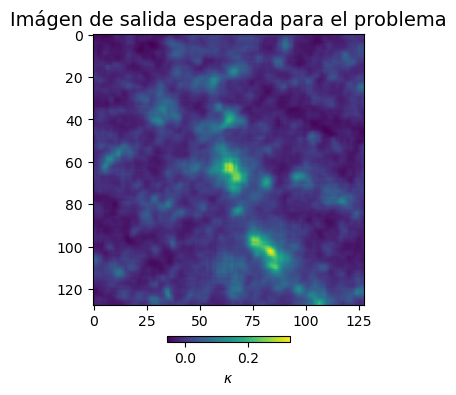

In [11]:
data = glob.glob("submissions/private_partition_14/purrfectpredict/*.npy")
plot_kappa(data)